In [1]:
#Skalowanie daje slabe wyniki, bez skalowania jest duzo lepiej
#batch normalization polepszylo znaczaco wyniki
#

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from tensorflow.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
tf.get_logger().setLevel('INFO')
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda, RNN, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy, MSE
# import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from datetime import datetime
# from keras import backend as K
from tensorflow.keras.utils import plot_model
from mpl_toolkits.mplot3d import Axes3D
# import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score

# Generate data

In [4]:
def generate_line(a, b, n=32, noise=0):
    x = np.arange(n)
    return a * x + b + np.random.normal(0, noise, n)

def generate_lines(a, bs, n_train, c, lines, labels):
    for b in bs:
        generated_lines = np.array([generate_line(a, b, noise=0.005) for _ in range(int(n_train/16))])
        generated_labels = np.array([c for _ in range(int(n_train/16))])
        if lines.size == 0:
            lines = generated_lines
            labels = generated_labels
        else:
            lines = np.concatenate((lines, generated_lines))
            labels = np.concatenate((labels, generated_labels))
    return lines, labels
    
def generate_lines_set(n_train):    
    lines = np.array([])
    labels = np.array([])

    lines, labels = generate_lines(0, [0, .4, .8, 1.2, 1.6, 2], n_train, 'g', lines, labels)
    lines, labels = generate_lines(0.01, [.2, .6, 1, 1.4, 1.8], n_train, 'r', lines, labels)
    lines, labels = generate_lines(-0.01, [.2, .6, 1, 1.4, 1.8], n_train, 'b', lines, labels)

    return np.array(lines), np.array(labels)
    

In [5]:
n_lines = 64000
n_types = 16
x_train, y_train = generate_lines_set(64000)

# Scale data

In [6]:
x_train = (x_train - np.amin(x_train)) / (np.amax(x_train) - np.amin(x_train))

In [7]:
# scaler = StandardScaler()
# scaler.fit(x_train)
# x_train = scaler.transform(x_train)

# Plot data

4000


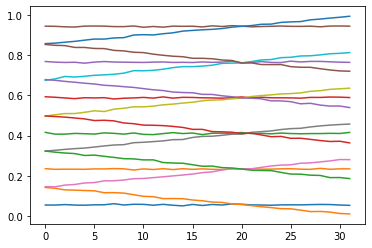

In [8]:
plot_lines = np.concatenate((x_train[1000:1010], x_train[11000:11010], x_train[21000:21010], x_train[31000:31010],x_train[41000:41010],x_train[51000:51010])) 
index = 10
interval = int(n_lines / n_types)
print(interval)
while index < n_lines:
    plt.plot(x_train[index])
    index += interval

# Create model

In [34]:
original_dim = 32
input_shape = (original_dim, )
intermediate_dim = 16
batch_size = 128
latent_dim = 8
epochs = 1

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim), stddev=0.1)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [35]:
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
x = BatchNormalization()(x)
z_mean = Dense(latent_dim, name='z_mean')(x)

z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = BatchNormalization()(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 32)]         0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 16)           528         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 16)           64          dense_3[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 8)            136         batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [36]:
models = (encoder, decoder)
reconstruction_loss = MSE(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + (1 * kl_loss))
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
# vae.summary()

# Learn data

In [89]:
for i in range(1):
    vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size)
    z_mean, _, _ = encoder.predict(x_train, batch_size=batch_size)
    print(f"{davies_bouldin_score(z_mean, y_train)} Davies-Boulding Score") # The lower the better
    # print(f"{silhouette_score(z_mean, y_train)} Silhouette Score")
    print(f"{calinski_harabasz_score(z_mean, y_train)} Calinski-Harabasz Score") # The higher the better

500/500 [==============================] - 0s 872us/step - loss: 0.2342
3.965096477244247 Davies-Boulding Score
4003.8703792786614 Calinski-Harabasz Score


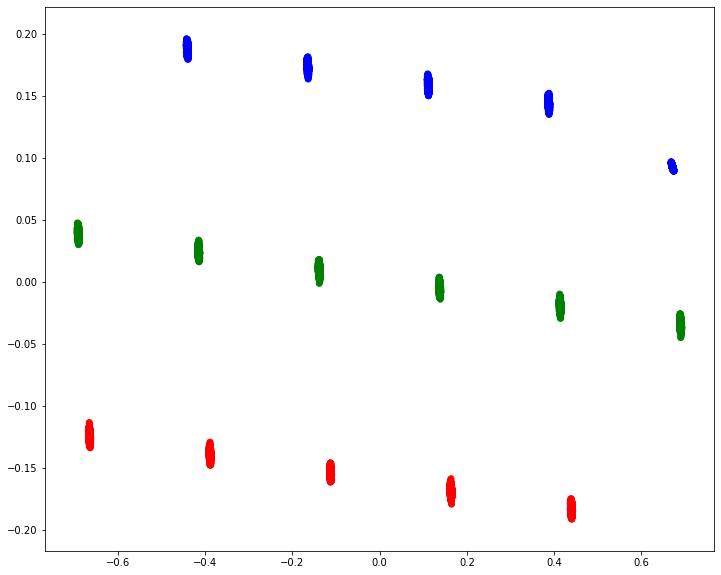

In [90]:
z_mean, _, _ = encoder.predict(x_train, batch_size=batch_size)
z_mean = PCA(n_components=2).fit_transform(z_mean)

fig = plt.figure(figsize=(12,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(z_mean[:, 0], z_mean[:, 1], z_mean[:, 2],  c=y_train)

plt.scatter(z_mean[:, 0], z_mean[:, 1],  c=y_train)

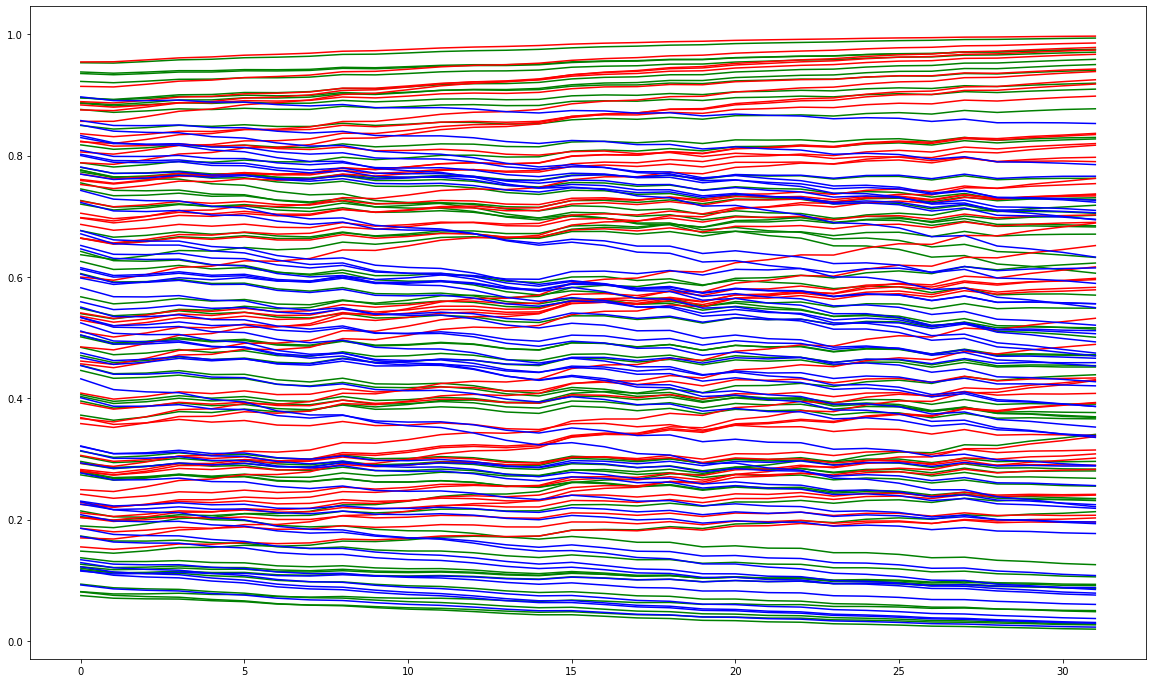

In [91]:
res = vae.predict(x_train, batch_size=128)
plt.figure(figsize=(20,12))
index = 10
interval = int(n_lines / n_types)
while index < n_lines:
    for i in range(index, index + 10, 1):
        plt.plot(res[i], c=y_train[i])
    index += interval

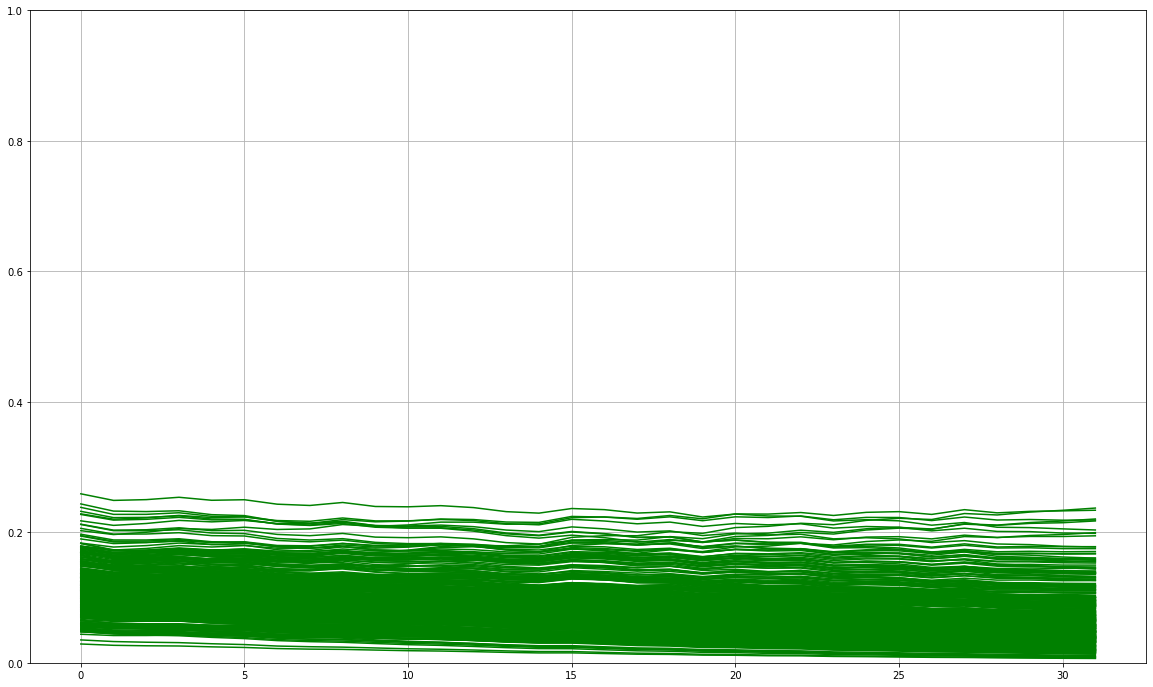

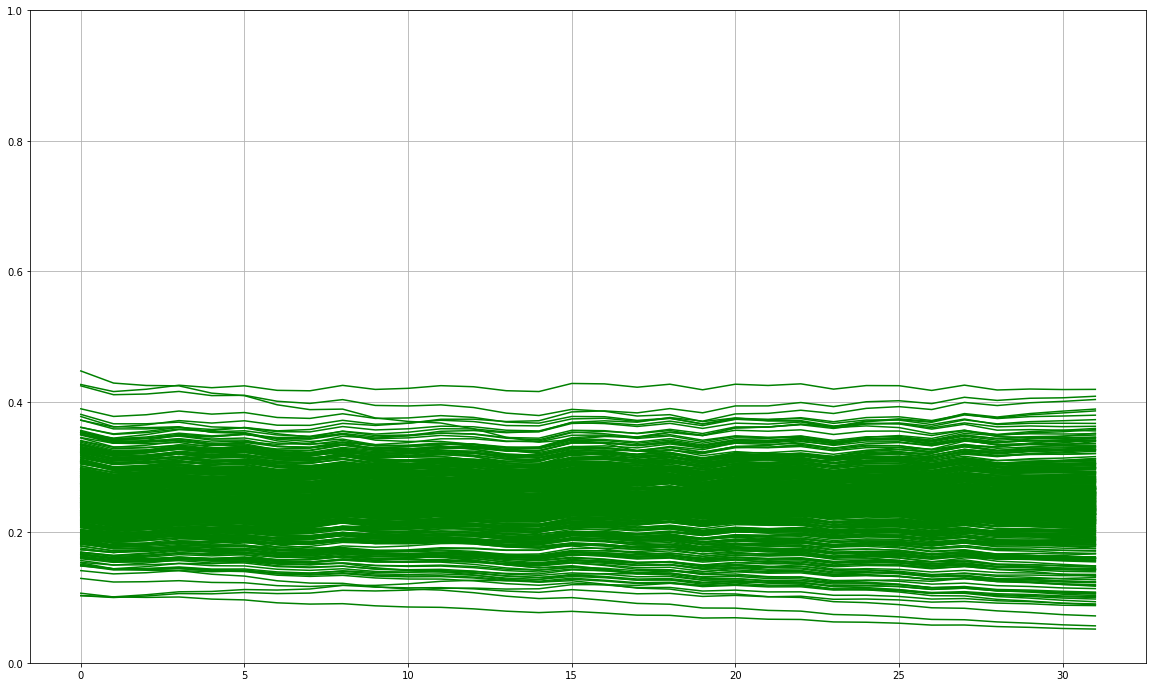

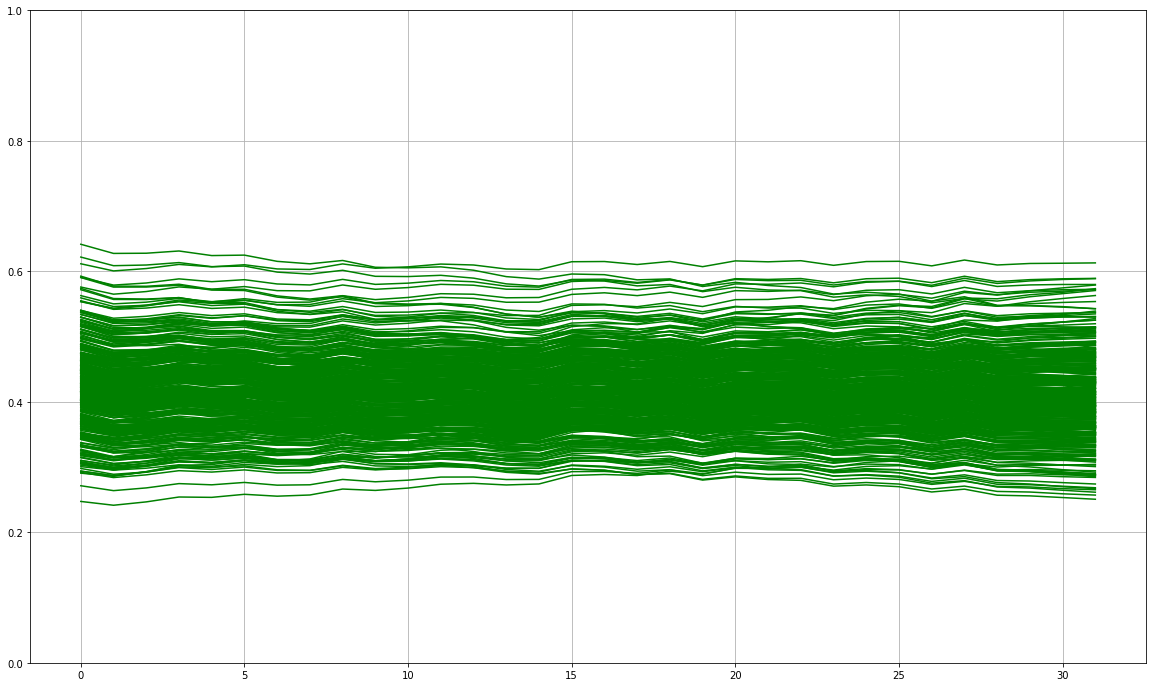

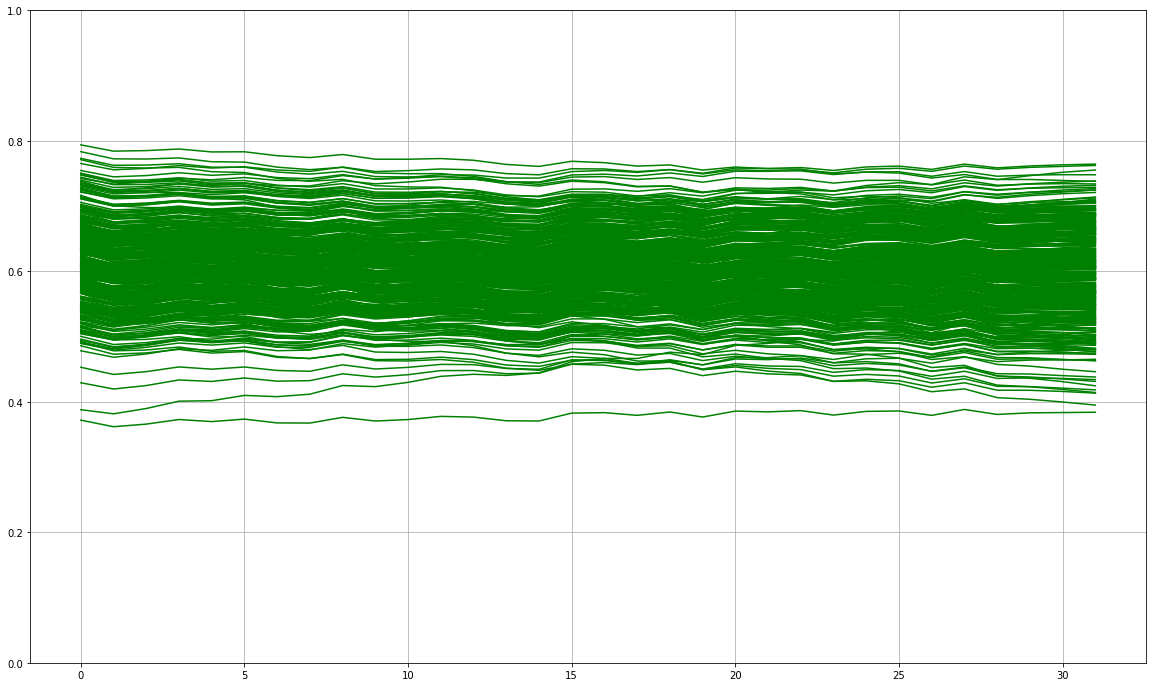

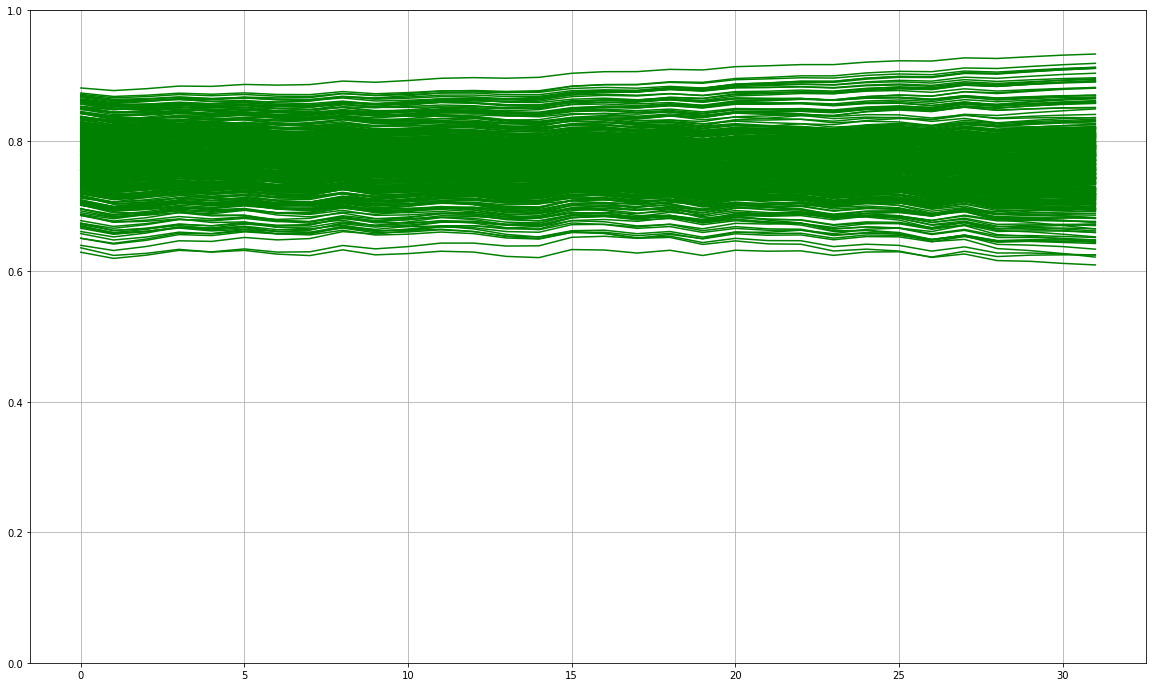

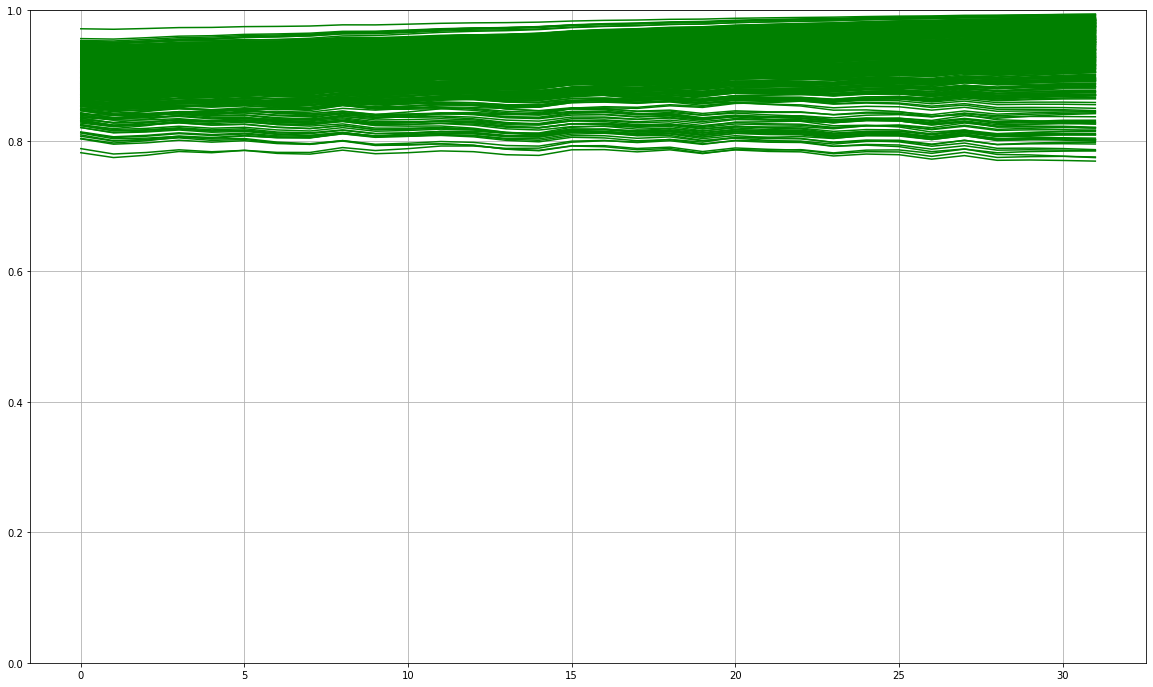

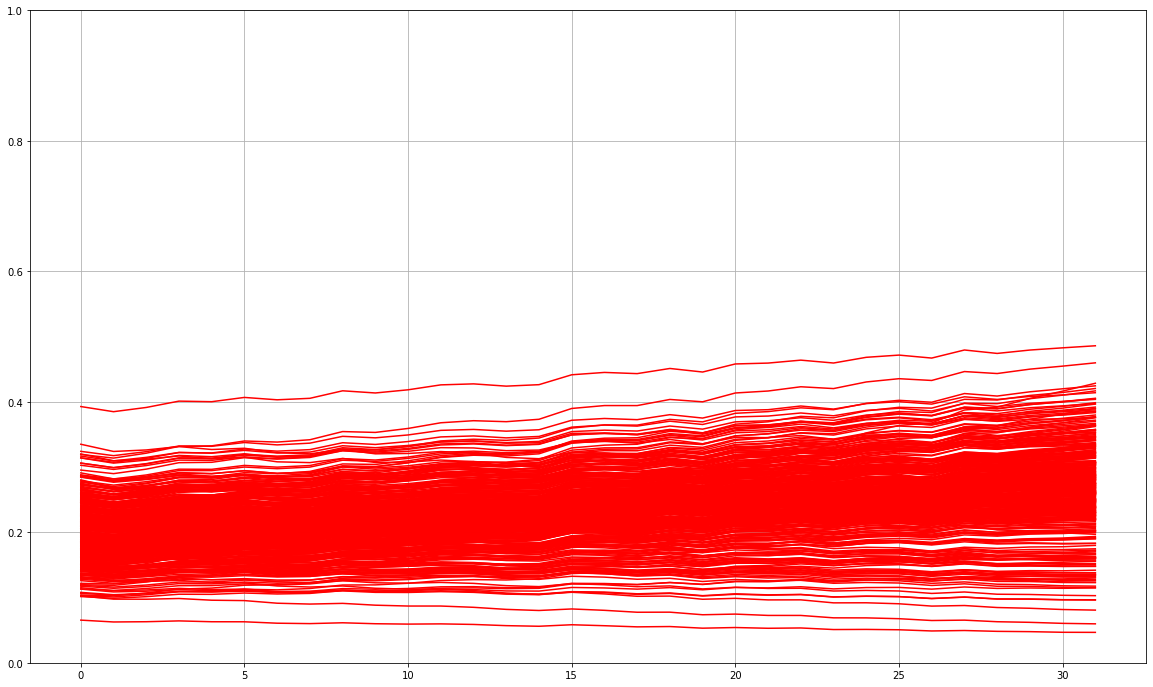

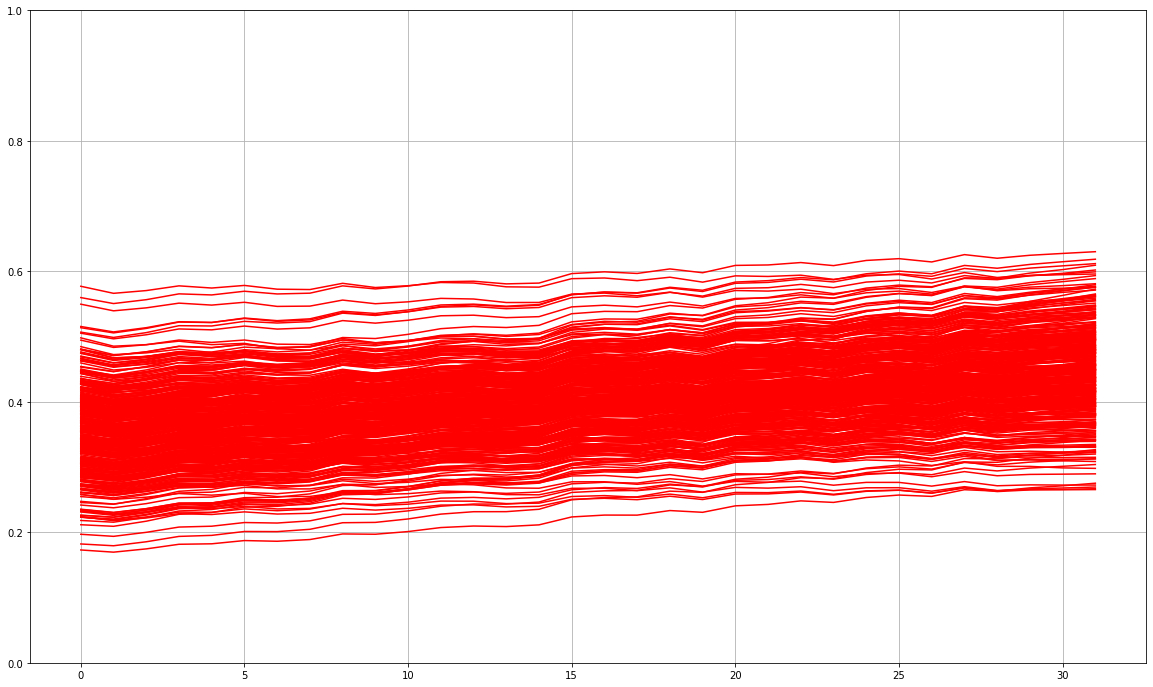

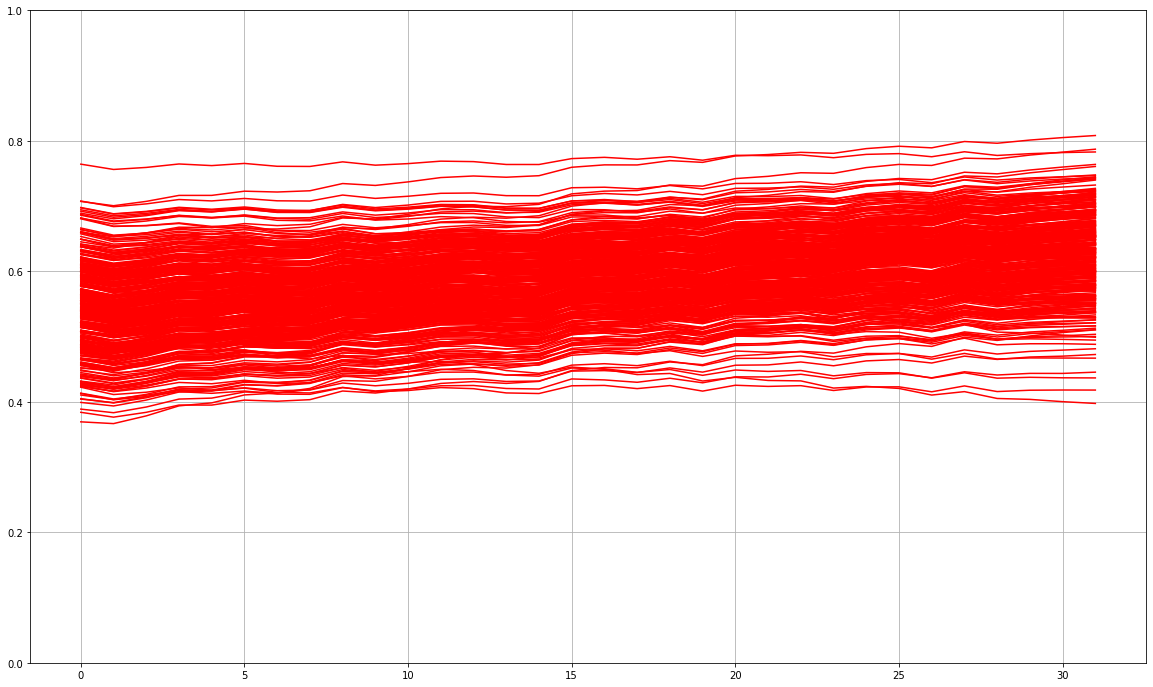

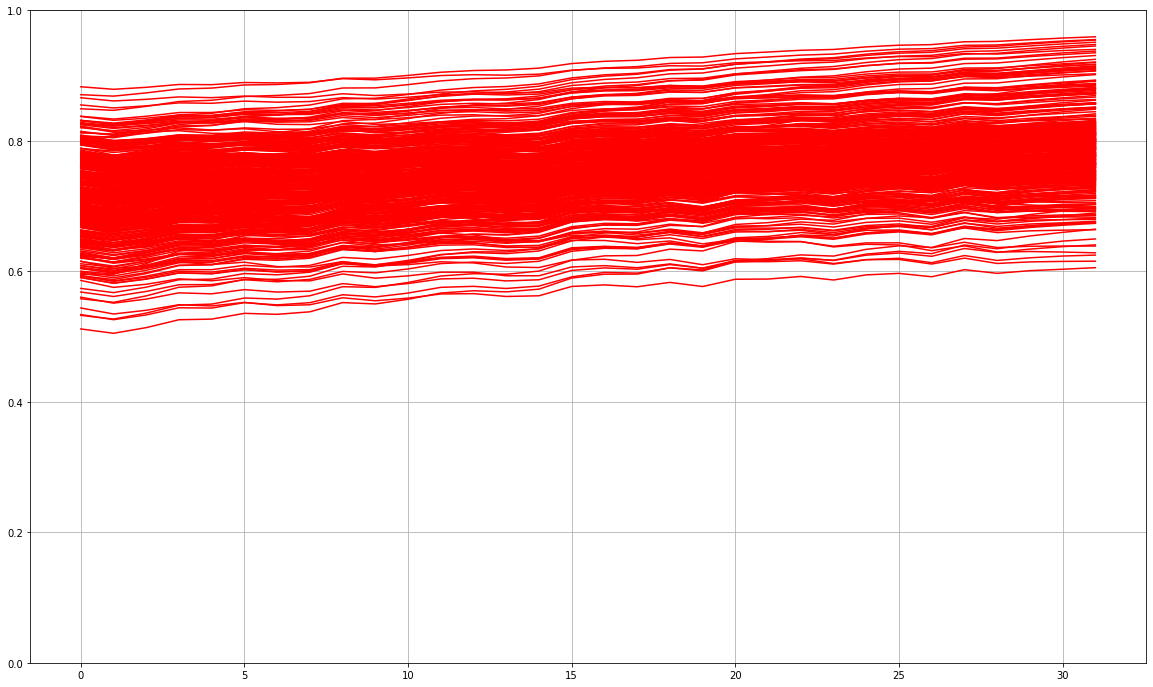

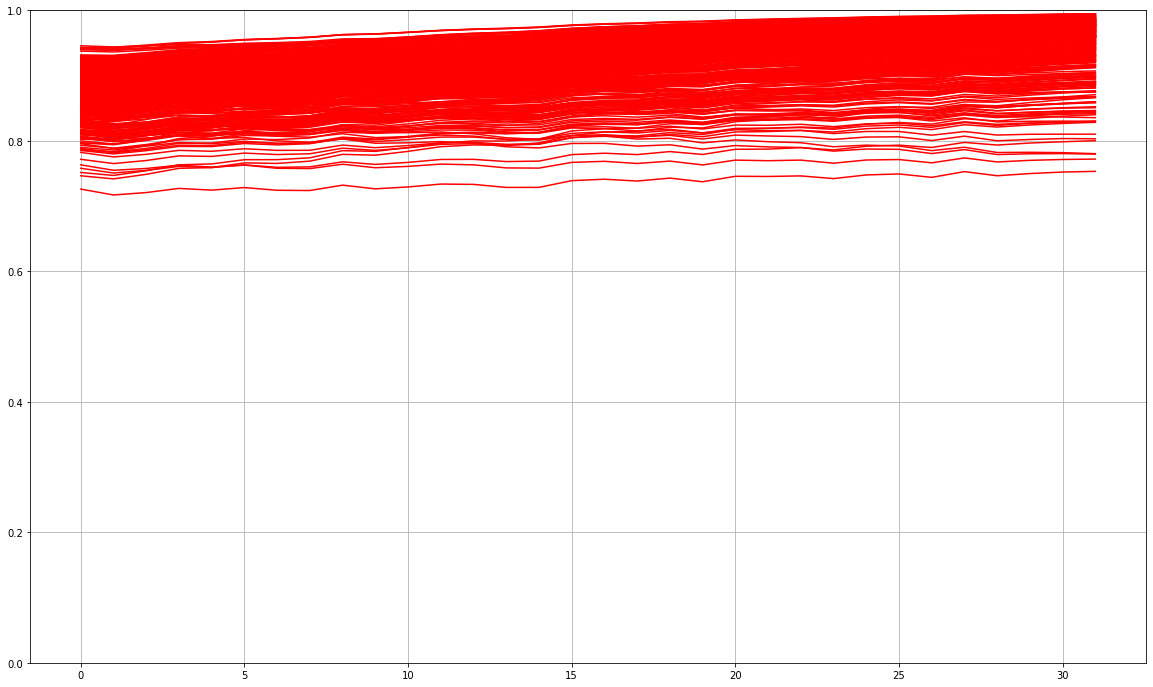

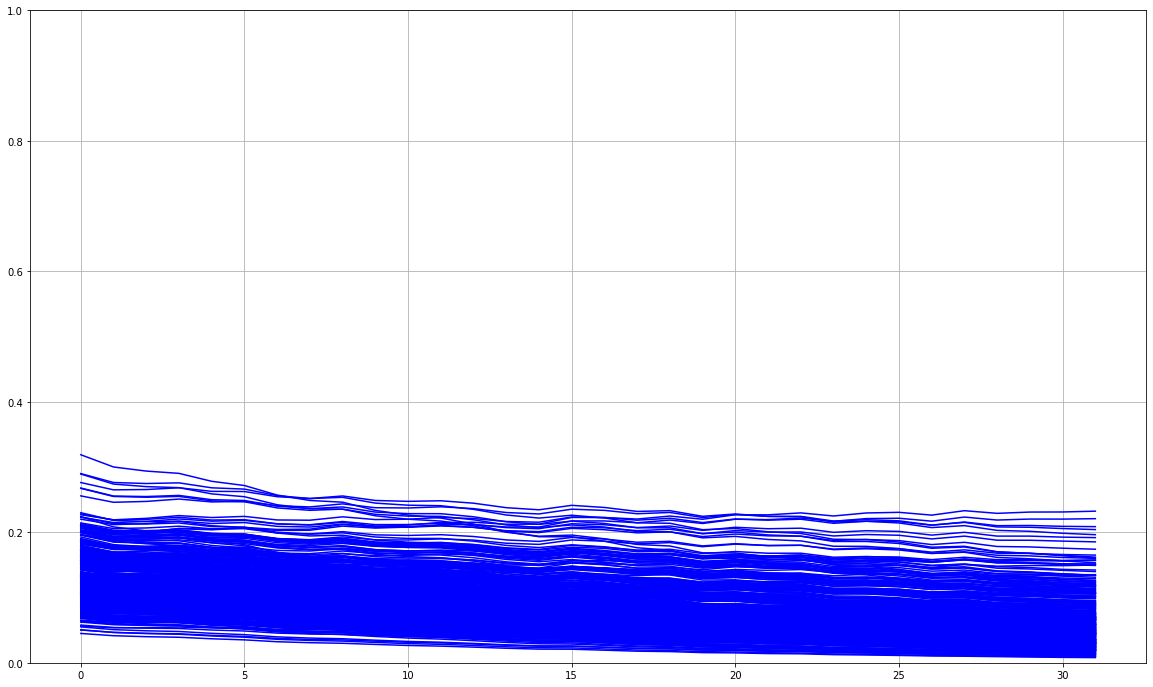

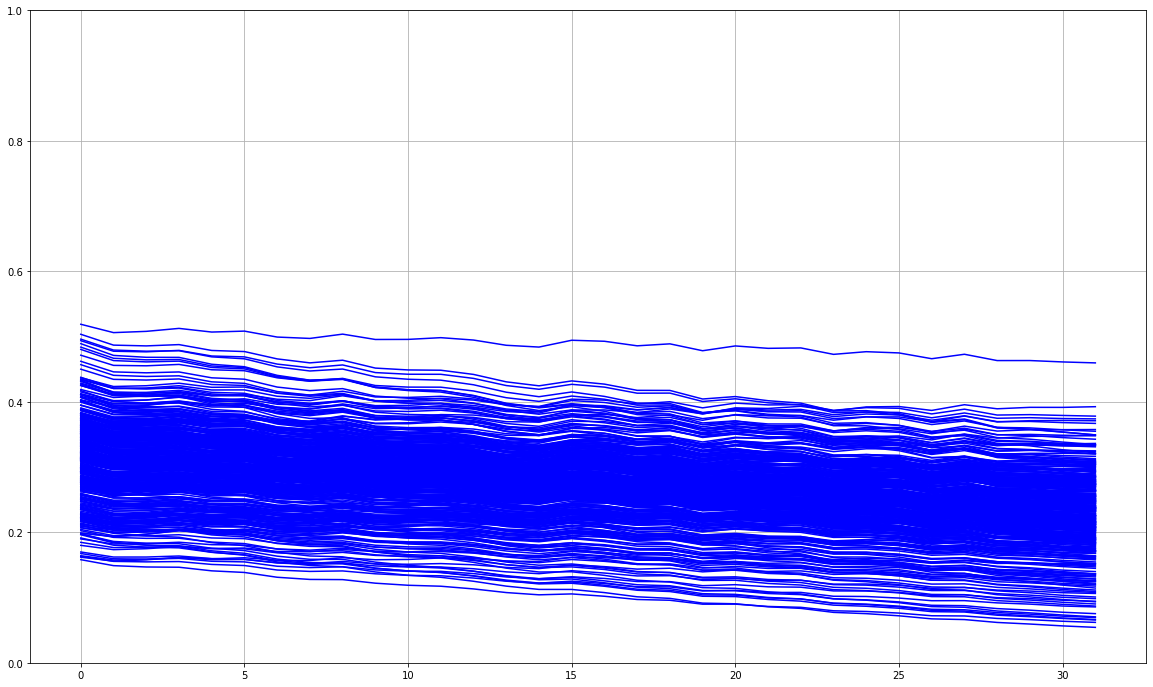

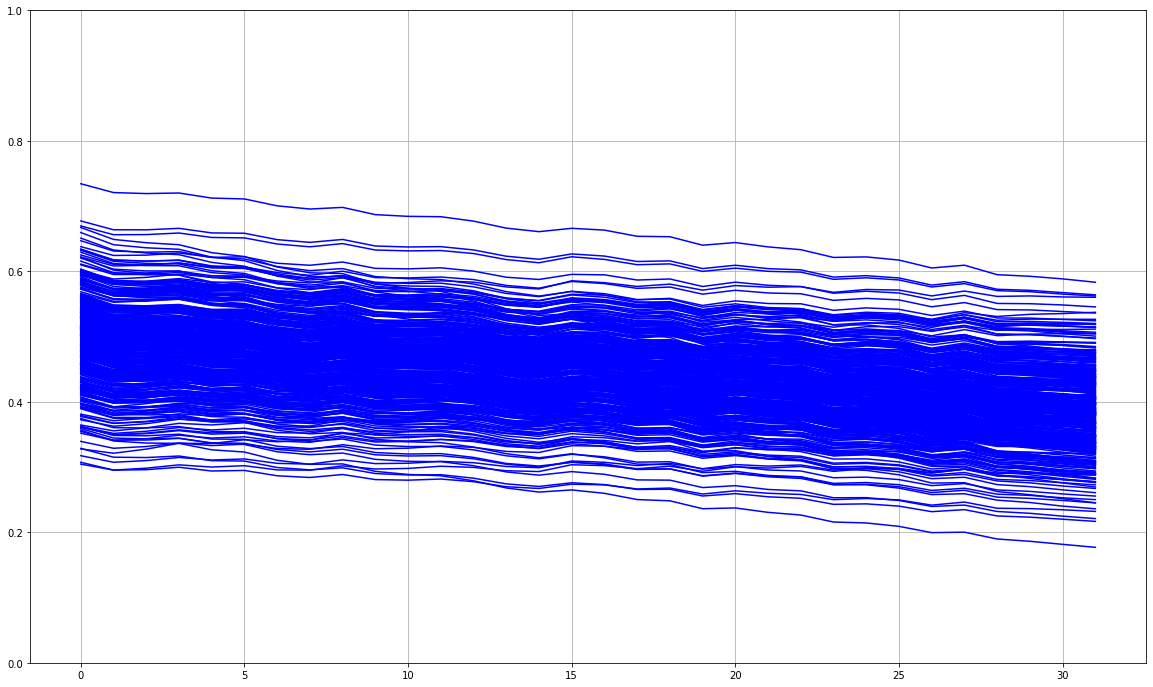

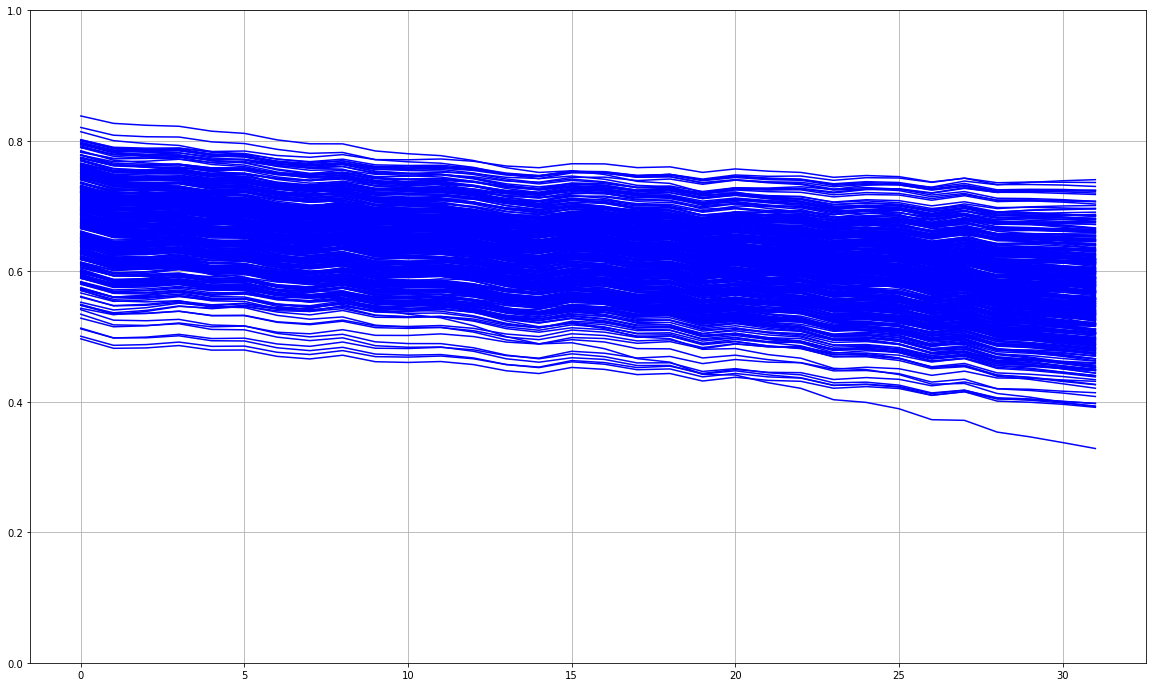

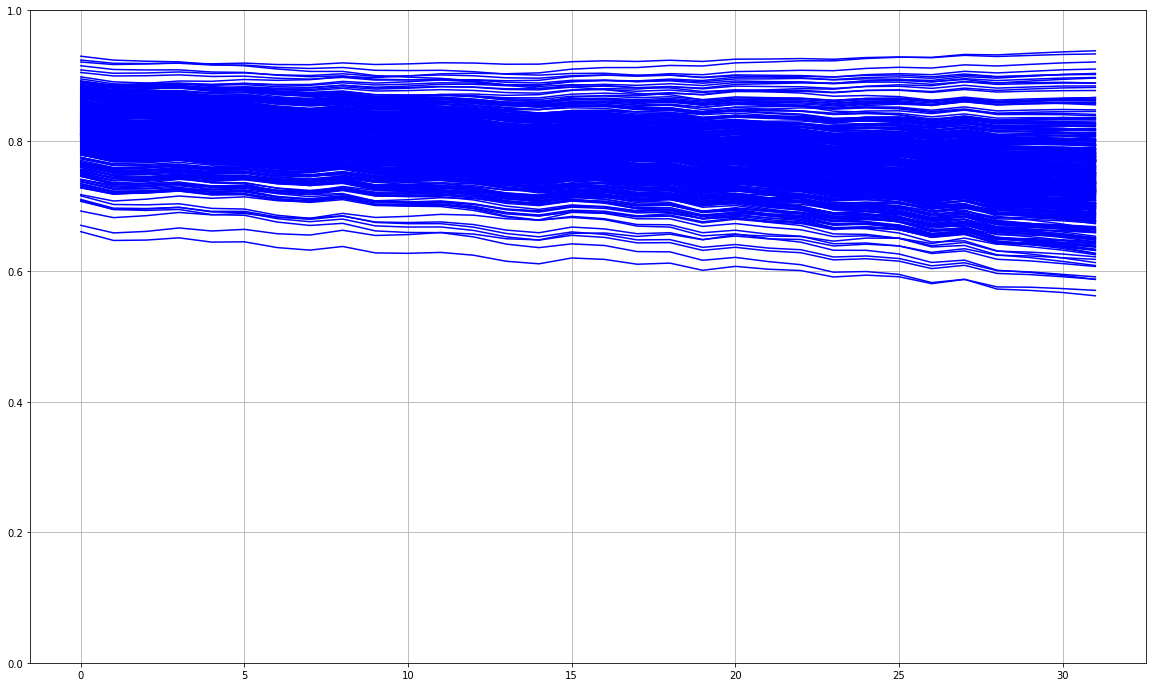

In [92]:
res = vae.predict(x_train, batch_size=128)
index = 10
interval = int(n_lines / n_types)
while index < n_lines:
    plt.figure(figsize=(20,12))
    plt.grid()
    plt.ylim((0,1))
    for i in range(index, index + 400, 1):
        plt.plot(res[i], c=y_train[i])
    index += interval

In [16]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [17]:
path = "C:/Studia/Magisterka/Faints-Prediction/"
BP_filename = "BP.csv"
HR_filename = "HR.csv"

train_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/training_set.txt").values.tolist()]
test_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/test_set.txt").values.tolist()]
validation_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/validation_set.txt").values.tolist()]
all_indices = train_indices + test_indices + validation_indices

In [18]:
BP_data = pd.read_csv(path + "DATA/" + BP_filename, low_memory=False)[all_indices]
HR_data = pd.read_csv(path + "DATA/" + HR_filename, low_memory=False)[all_indices]
labels = {col: BP_data[col].iloc[0] for col in BP_data}

BP_max_value = BP_data.iloc[1:].astype(np.float32).max().max()
BP_min_value = BP_data.iloc[1:].astype(np.float32).min().min()
HR_max_value = HR_data.iloc[1:].astype(np.float32).max().max()
HR_min_value = HR_data.iloc[1:].astype(np.float32).min().min()

BP_scaler = MinMaxScaler().fit(np.array([BP_min_value, BP_max_value]).reshape(-1,1))
HR_scaler = MinMaxScaler().fit(np.array([HR_min_value, HR_max_value]).reshape(-1,1))

BP_data_scaled = BP_data.iloc[1:].astype(np.float32).copy()
BP_data_scaled[all_indices] = BP_scaler.transform(BP_data_scaled[all_indices])

HR_data_scaled = HR_data.iloc[1:].astype(np.float32).copy()
HR_data_scaled[all_indices] = HR_scaler.transform(HR_data_scaled[all_indices])

In [27]:
# SMOOTHING
BP_data_scaled_averaged = BP_data_scaled.rolling(50).mean()
HR_data_scaled_averaged = HR_data_scaled.rolling(50).mean()

In [148]:
x = np.array(BP_data_scaled_averaged['375'])
# x = np.array(BP_data['320'][1:]).astype(np.float32)
x = x[~np.isnan(x)]
# x = moving_average(x, 50)
x = x[:-(x.shape[0] % 32)]
# x = (x - np.amin(x)) / (np.amax(x) - np.amin(x))

(0, 1)

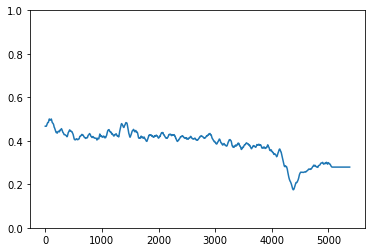

In [146]:
plt.plot(x)
plt.ylim(0,1)

In [149]:
xs = np.array(np.array_split(x, int(len(x)/32)))
xs.shape

(168, 32)

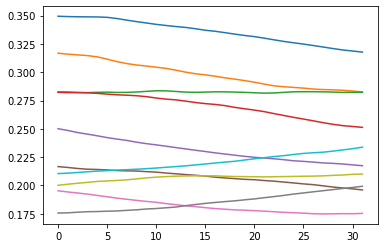

In [150]:
for e in xs[130:140]:
    plt.plot(e)

In [135]:
# xs = np.array([elem[::4] for elem in xs])

In [136]:
x_test = np.concatenate((x_train, xs[:]))
y_test = np.concatenate((y_train, np.array(['k' for _ in range(len(xs[:]))])))

# y_test = np.concatenate((y_train, np.array(['k' for _ in range(len(xs[:130]))])))
# y_test = np.concatenate((y_test, np.array(['m' for _ in range(len(xs[130:137]))])))
# y_test = np.concatenate((y_test, np.array(['k' for _ in range(len(xs[137:]))])))

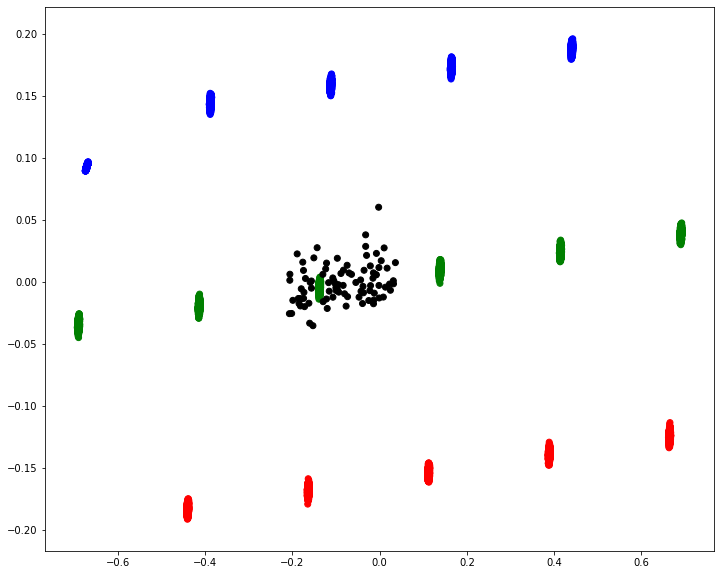

In [137]:
z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
z_mean = PCA(n_components=2).fit_transform(z_mean)

fig = plt.figure(figsize=(12,10))


# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(z_mean[:, 0], z_mean[:, 1], z_mean[:, 2],  c=y_train)

plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)

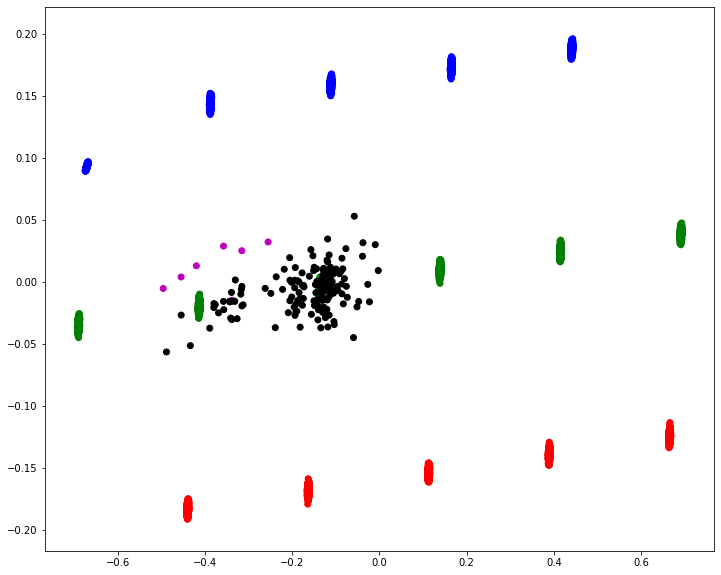

In [113]:
z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
z_mean = PCA(n_components=2).fit_transform(z_mean)

fig = plt.figure(figsize=(12,10))


# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(z_mean[:, 0], z_mean[:, 1], z_mean[:, 2],  c=y_train)

plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)

(0, 1)

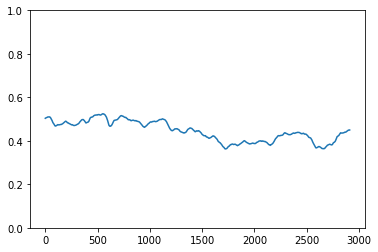

In [144]:
plt.plot(x)
plt.ylim(0,1)